# Credit Card Fraud Detection

Problem Description: Given a credit card transaction, determine if transaction is Genuine or Fraud.

Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud/home 

ML Challenge: Anamoly Detection, Highly Skewed Dataset
        

In [29]:
#imports
import pandas as pd
import math
import numpy as np
import MyUtils as myutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

%matplotlib inline

In [30]:
#Read Dataset
dfAll=pd.read_csv("creditcard.csv")
print(dfAll.columns)
print(dfAll['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
0    284315
1       492
Name: Class, dtype: int64


<u>Observations</u>

1. Dataset is highly skewed with only 0.172 Fraud Transactions
2. Features: V1-V28 are PCA Output; Amount and Time 

This means we will be able to do very limited feature engg.!!

1. To begin with lets explore PCA outputs for both Classes

In [ ]:
plt.figure(figsize=(12,8*4))
gs = gridspec.GridSpec(8, 4)
for i, cn in enumerate(dfAll):
    if cn=="Class":
        continue
    ax = plt.subplot(gs[i])
    sns.distplot(dfAll[cn][dfAll['Class']==0], bins=50)
    sns.distplot(dfAll[cn][dfAll['Class']==1], bins=50)
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(cn))
plt.show()

The above results show that many of later features are very similar(mean and stddev) for both classes and hence may not contribute much to ml.
Hence removing them.

In [31]:
dropCols=['Time','V13','V15','V21','V22','V23','V24','V25','V26','V27','V28']

dfAll=dfAll.drop(['Time'],axis=1) #Not useful in this particular analysis


## Lets Define Some necessary Functions

In [32]:
def plotProbs(X_val,y_val,col):
	dfNormal=X_val[y_val==0]
	dfFraud=X_val[y_val==1]
	import seaborn as sns
	import matplotlib.gridspec as gridspec
	gs = gridspec.GridSpec(1, 2)
	plt.figure(figsize=(7,5))
	ax = plt.subplot(gs[0])
	ax.set_title(col+' Distribution for normal')
	sns.distplot(dfNormal[col], bins=50)
	ax = plt.subplot(gs[1])
	ax.set_title(col+' Distribution for  fraud')
	sns.distplot(dfFraud[col], bins=50)
	#ax.set_xlabel('')
	
	plt.show()



def feature_normalize(dataset):
    #mu = np.mean(dataset,axis=0)
    #sigma = np.std(dataset,axis=0)
    mu=np.min(dataset,axis=0)
    sigma=np.max(dataset,axis=0)-np.min(dataset,axis=0)
	
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)


def getMeanStdProb(df,mu=None,sigma=None):
	if mu is None:
		mu, sigma=estimateGaussian(df)
		
	df['prob']=multivariateGaussian(df,mu,sigma)
	return df,mu, sigma


def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon,epsilons

## Split Data into Train and Test Set

In [33]:
outputVarName='Class'
crossVal=0
X_trainVal, X_test, y_trainVal, y_test = myutils.GetTrainTest(dfAll,outputVarName)

print(y_trainVal.value_counts())
print(y_test.value_counts())

0    1248
1     394
Name: Class, dtype: int64
0    280587
1        20
Name: Class, dtype: int64


## Split Data into Train and Val Set

0    998
1    315
Name: Class, dtype: int64
0    250
1     79
Name: Class, dtype: int64


c:\users\admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\admin\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

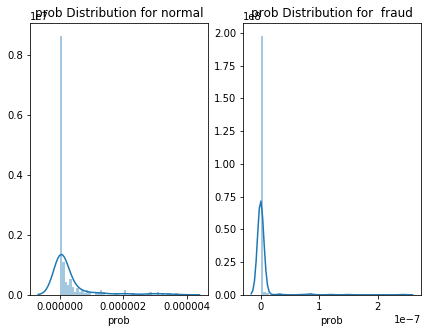

c:\users\admin\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



------Val-----
[[0.588      0.412     ]
 [0.04060914 0.95939086]]
0.9593908629441624 0.588
eps : 3.7122403550093877e-09
              precision    recall  f1-score   support

      Normal       0.90      0.59      0.71       250
       Fraud       0.79      0.96      0.86       394

   micro avg       0.82      0.82      0.82       644
   macro avg       0.84      0.77      0.79       644
weighted avg       0.83      0.82      0.80       644

[[147 103]
 [ 16 378]]
0    998
1    315
Name: Class, dtype: int64
0    250
1     79
Name: Class, dtype: int64


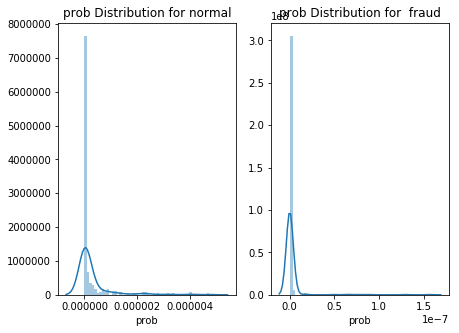


------Val-----
[[0.524      0.476     ]
 [0.03299492 0.96700508]]
0.9670050761421319 0.524
eps : 4.731770165552278e-09
              precision    recall  f1-score   support

      Normal       0.91      0.52      0.66       250
       Fraud       0.76      0.97      0.85       394

   micro avg       0.80      0.80      0.80       644
   macro avg       0.84      0.75      0.76       644
weighted avg       0.82      0.80      0.78       644

[[131 119]
 [ 13 381]]
0    998
1    315
Name: Class, dtype: int64
0    250
1     79
Name: Class, dtype: int64


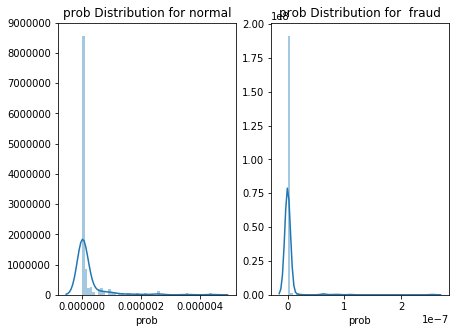


------Val-----
[[0.464      0.536     ]
 [0.02791878 0.97208122]]
0.9720812182741116 0.464
eps : 4.414144118817737e-09
              precision    recall  f1-score   support

      Normal       0.91      0.46      0.62       250
       Fraud       0.74      0.97      0.84       394

   micro avg       0.77      0.77      0.77       644
   macro avg       0.83      0.72      0.73       644
weighted avg       0.81      0.77      0.75       644

[[116 134]
 [ 11 383]]
0    999
1    315
Name: Class, dtype: int64
0    249
1     79
Name: Class, dtype: int64


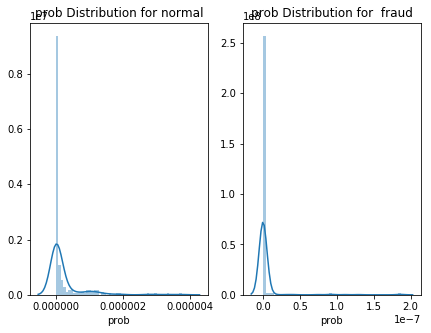


------Val-----
[[0.51405622 0.48594378]
 [0.04060914 0.95939086]]
0.9593908629441624 0.5140562248995983
eps : 3.7517982992491554e-09
              precision    recall  f1-score   support

      Normal       0.89      0.51      0.65       249
       Fraud       0.76      0.96      0.85       394

   micro avg       0.79      0.79      0.79       643
   macro avg       0.82      0.74      0.75       643
weighted avg       0.81      0.79      0.77       643

[[128 121]
 [ 16 378]]
0    999
1    316
Name: Class, dtype: int64
0    249
1     78
Name: Class, dtype: int64


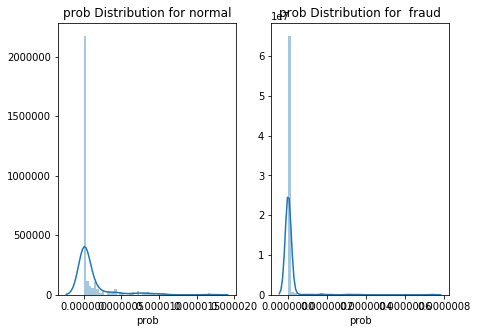


------Val-----
[[0.51004016 0.48995984]
 [0.03553299 0.96446701]]
0.9644670050761421 0.5100401606425703
eps : 1.681097422833287e-08
              precision    recall  f1-score   support

      Normal       0.90      0.51      0.65       249
       Fraud       0.76      0.96      0.85       394

   micro avg       0.79      0.79      0.79       643
   macro avg       0.83      0.74      0.75       643
weighted avg       0.81      0.79      0.77       643

[[127 122]
 [ 14 380]]


In [34]:
grandRes=[]
grandRes2=[]	
	
for X_train, X_val ,y_train, y_val in myutils.GetkFoldedTrainVal(X_trainVal,y_trainVal):
	crossVal+=1
	print(y_train.value_counts())
	print(y_val.value_counts())
	
	#for anamoly detection prepare train dataset only on  only normal values
	X_val=X_val.append(X_train[y_train==1])
	y_val=y_val.append(y_train[y_train==1])
	X_train=X_train[y_train==0]
	y_train=y_train[y_train==0]
	
	#Now Training has only postive examples as desired for Gaussian Based ANAMOLY DETECTION
	
	
	def PreprocessDataset(df):
		df['Amount']=np.log(df['Amount']+1)
		df['V1']=df['V1']+100
		df['V1']=df['V1']**0.1
		df=df+1
		
		#if dfStd is None:
		#	dfStd=df.describe()
		
		#df2=feature_normalize(df)
		#df2=(df-dfStd.loc['mean'])/dfStd.loc['std']
		
		return df
	
	
	X_train=PreprocessDataset(X_train)
	X_val=PreprocessDataset(X_val)
	

	
	
	X_train,muTrain,sigmaTrain=getMeanStdProb(X_train)
	X_val,dfpxVal,_=getMeanStdProb(X_val,muTrain,sigmaTrain)
	
	"""
	plt.figure(figsize=(12,4))
	sns.distplot(X_train['prob'], bins=5)
	sns.distplot(X_val['prob'], bins=5)
	plt.show()
	"""
	
	#myutils.fnPlotCols(X_train,colNames=['prob'],num_bins=100)
	X_train['prob'].describe()
	X_val['prob'].describe()
	eps=np.max(X_train['prob'])
	
	
	
	def CalculateResults(Phase,X,yactual,eps,epsilons,plotROC=False):
		print()
		print(Phase)
		Pred=X['prob']<eps
		acc_score,rs,f1score,cnf_matrix=myutils.GetScores(yactual,Pred,['Normal','Fraud'])
		cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
		print(cm)
		print(cm[1,1],cm[0,0])
		print("eps : "+str(eps))
		#print(acc_score)
		print(f1score)
		print(cnf_matrix)
		
		#Accuracy approx Precision of Normal class bcoz of heavily imbalanced dataset 
		grandRes.append((crossVal,eps,round(acc_score,2),round(cm[1,1],4),round(cm[0,0],4),muTrain,sigmaTrain,epsilons))
		grandRes2.append((cnf_matrix,f1score))
		if plotROC:
			myutils.PlotRecallCurve(yactual,Pred)
			
			
	plotProbs(X_val,y_val,'prob')
	fscore, ep,epsilons = selectThresholdByCV(X_val['prob'],y_val)
	CalculateResults("------Val-----",X_val,y_val,ep,epsilons)

In [35]:
dfRes=pd.DataFrame(grandRes,columns=['CVNum','EPS','PrecNormal','FRecall','NRecall','muTrain','sigTrain','epsilons'])

In [36]:
dfRes

,CVNum,EPS,PrecNormal,FRecall,NRecall,muTrain,sigTrain,epsilons
0,1,3.7122403550093877e-09,0.82,0.9594,0.5880,V1 2.584933 V2 0.957969 V3 ...,"[[9.009498315547156e-06, -3.916050144635397e-0...","[0.0, 3.7122403550093877e-09, 7.42448071001877..."
1,2,4.731770165552278e-09,0.80,0.9670,0.5240,V1 2.584868 V2 1.015497 V3 ...,"[[9.378256715831177e-06, -0.000205903684351006...","[0.0, 4.731770165552278e-09, 9.463540331104556..."
2,3,4.414144118817737e-09,0.77,0.9721,0.4640,V1 2.584924 V2 0.999973 V3 ...,"[[9.201372980927028e-06, -0.000143222885696889...","[0.0, 4.414144118817737e-09, 8.828288237635474..."
3,4,3.7517982992491554e-09,0.79,0.9594,0.5141,V1 2.584890 V2 1.040114 V3 ...,"[[9.157895350292016e-06, -0.000389650069068365...","[0.0, 3.7517982992491554e-09, 7.50359659849831..."
4,5,1.681097422833287e-08,0.79,0.9645,0.5100,V1 2.585017 V2 0.997769 V3 ...,"[[6.76345420137884e-06, -0.0003676877485370225...","[0.0, 1.681097422833287e-08, 3.362194845666574..."


We can choose best mu depending upon tradeoff between Precision and Recall.

As this is fraud detection we will choose eps which gives maximum Fraud Recall which is index 2

In [37]:


bestIndex=2
bestMu,bestSigma,eps=dfRes['muTrain'][bestIndex],dfRes['sigTrain'][bestIndex],dfRes['EPS'][bestIndex]

print(eps)

X_testPro=PreprocessDataset(X_test)
X_testPro,dfpxTest,_=getMeanStdProb(X_testPro,bestMu,bestSigma)
#for eps in [1.4807699013771287e-17]:
#for eps in epsilons:	
		#CalculateResults("------Train-----",X_train,y_train,eps)
CalculateResults("------Test-----",X_testPro,y_test,eps,True)

4.414144118817737e-09

------Test-----
[[0.50518734 0.49481266]
 [0.05       0.95      ]]
0.95 0.5051873393991881
eps : 4.414144118817737e-09
              precision    recall  f1-score   support

      Normal       1.00      0.51      0.67    280587
       Fraud       0.00      0.95      0.00        20

   micro avg       0.51      0.51      0.51    280607
   macro avg       0.50      0.73      0.34    280607
weighted avg       1.00      0.51      0.67    280607

[[141749 138838]
 [     1     19]]


In [ ]:
## This method although gives very high recall, 